In [1]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from st_utils import get_gene_type, name_parser
from st_utils import correct_tissue_names, get_df_color
from st_utils import correct_platform_panel
from constants import CORRECT_PLATFORM_PANEL
from constants import SAMPLES,sample_color

pd.set_option('display.max_rows',999)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

wd = os.getcwd()
print (f'working directory: {wd}')

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# SAMPLES = ['xenium_breast_htma',
#  'xenium_breast_normal',
#  'xenium_panhuman_htma',
#  'xenium_panhuman_normal',
#  'xenium_lung_htma',
#  'xenium_lung_normal',
#  'merscope_breast_htma',
#  'merscope_breast_normal',
#  'merscope_lung_htma',
#  'merscope_lung_normal',
#  'cosmx_multitissue_htma',
#  'cosmx_multitissue_normal']

SAMPLES


working directory: /mnt/disks/store/ist_benchmarking


['xenium_breast_htma',
 'xenium_breast_normal',
 'xenium_panhuman_htma',
 'xenium_panhuman_normal',
 'xenium_lung_htma',
 'xenium_lung_normal',
 'merscope_breast_htma',
 'merscope_breast_normal',
 'merscope_lung_htma',
 'merscope_lung_normal',
 'cosmx_multitissue_htma',
 'cosmx_multitissue_normal',
 '2024_xenium_breast_htma',
 '2024_xenium_breast_tumor2',
 '2024_merscope_breast_htma',
 '2024_merscope_breast_tumor2',
 '2024_cosmx_multitissue_htma',
 '2024_cosmx_multitissue_tumor2']

In [2]:
# get common genes
samples = []
sample_gene_list = {}
for sample in SAMPLES[::2]:
    print (sample)
    samples.append(sample)
    genes = pd.read_parquet(
        f'{wd}/data/cell_by_gene_csv/{sample}_cell_by_gene.parquet.gzip'
        ).columns[2:-2]
    
    filtered_genes = [gene for gene in genes if get_gene_type(gene) == 'gene']
    platform_panel = CORRECT_PLATFORM_PANEL['_'.join(sample.split('_')[-3:-1])]
    sample_gene_list[platform_panel] = filtered_genes

xenium_breast_htma
xenium_panhuman_htma
xenium_lung_htma
merscope_breast_htma
merscope_lung_htma
cosmx_multitissue_htma
2024_xenium_breast_htma
2024_merscope_breast_htma
2024_cosmx_multitissue_htma


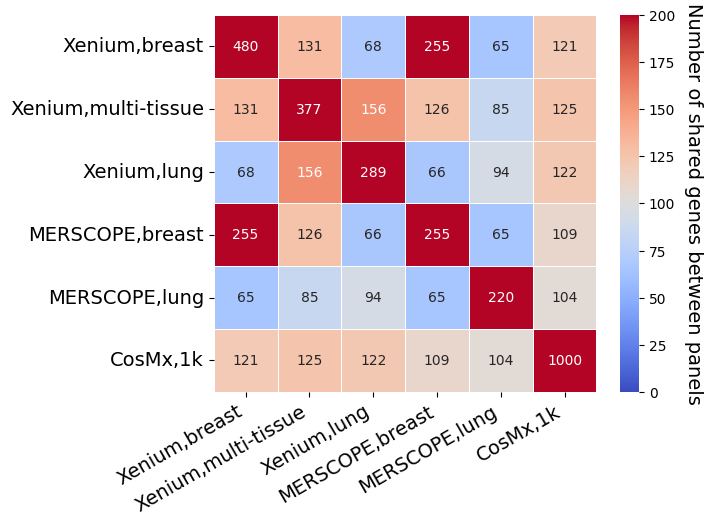

In [3]:
# Create an empty matrix to store the shared gene counts
matrix = []

# Create a list of sample names
sample_names = list(sample_gene_list.keys())

# Calculate shared gene counts and populate the matrix
for sample1 in sample_names:
    row = []
    genes1 = set(sample_gene_list[sample1])
    for sample2 in sample_names:
        genes2 = set(sample_gene_list[sample2])
        shared_genes = len(genes1.intersection(genes2))
        row.append(shared_genes)
    matrix.append(row)

matrix = np.array(matrix)
matrix = matrix+1

# Create the heatmap with annotations
plt.figure(figsize=(8, 5.3))  # Increase the figure width to accommodate the y-axis label
g = sns.heatmap(matrix, annot=True, cmap='coolwarm', linewidths=0.5,
                vmin=0, vmax=200, fmt=".0f", xticklabels=sample_names, yticklabels=sample_names)
cbar = g.collections[0].colorbar

# Adjust the position and size of the colorbar
cbar.ax.set_position([0.91, 0.1, 0.02, 0.77])  # Adjust the first and third values
cbar.ax.set_ylabel(f"Number of shared genes between panels", rotation=270, labelpad=20, fontsize=14)
plt.xlabel('')
plt.ylabel('')

fontsize = 14
xlabels = g.get_xticklabels()
g.set_xticklabels(xlabels, fontsize=fontsize, rotation=30, ha="right")

ylabels = g.get_yticklabels()
g.set_yticklabels(ylabels, fontsize=fontsize)

plt.tight_layout()
plt.savefig(f'{wd}/figures/Fig_1/supp_1_shared_gene.png', dpi=250, transparent=True)
plt.savefig(f'{wd}/figures/Fig_1/supp_1_shared_gene.eps', dpi=250, transparent=True)
plt.show()

# Metric (transcript/cell, unique genes/cell) heatmap

In [4]:
sample_gene_list = {}
samples = []

for sample in SAMPLES:
    if 'merscope_lung' in sample:
        continue
    print (sample)
    samples.append(sample)
    genes = pd.read_parquet(
        f'data/cell_by_gene_csv/{sample}_cell_by_gene.parquet.gzip'
        ).columns[2:-2]
    
    sample_gene_list[sample] = genes

common_genes = set(sample_gene_list[samples[0]])
for sample in samples[1:]:
    common_genes &= set(sample_gene_list[sample])
common_genes  = list(common_genes)
print (f'{len(common_genes)} commom genes')

xenium_breast_htma
xenium_breast_normal
xenium_panhuman_htma
xenium_panhuman_normal
xenium_lung_htma
xenium_lung_normal
merscope_breast_htma
merscope_breast_normal
cosmx_multitissue_htma
cosmx_multitissue_normal
2024_xenium_breast_htma
2024_xenium_breast_tumor2
2024_merscope_breast_htma
2024_merscope_breast_tumor2
2024_cosmx_multitissue_htma
2024_cosmx_multitissue_tumor2
40 commom genes


In [5]:
if not os.path.exists(f'{wd}/data/single_cell_metrics'):
    os.makedirs(f'{wd}/data/single_cell_metrics')

for common in [False]:
    metric = 'transcript_counts'
    cell_by_gene_both = pd.DataFrame()

    df_m = pd.DataFrame()
    for sample in SAMPLES:
        # if sample_key1 in SAMPLE or sample_key2 in SAMPLE:
        if 'merscope_lung' in sample:
            continue

        print (sample)
        df_c = pd.read_parquet(
            f'data/cell_level_csv/{sample}_cell_level.parquet.gzip'
            )[['cell_id','tissue_type','core','transcript_counts']]
        df_c = correct_tissue_names(sample,df_c)
        df_c = df_c.loc[~df_c['cell_id'].str.contains('-1_region')]

        
        df_c = df_c.rename(columns={'transcript_counts':'transcript_counts_given'})
        df_c = df_c.loc[df_c['tissue_type']!='Marker']
        df_c['core'] = df_c['core'].astype(int)

        df_c['core'] += (300 if 'tumor2' in sample else 0) + (200 if 'normal' in sample else 0)
        df_c['platform'] = name_parser(sample)[0].upper()
        df_c['panel'] = name_parser(sample)[1].capitalize()
        df_c['tma'] = name_parser(sample)[2].upper()
        df_c['platform_panel'] = df_c.apply(lambda row: f"{row['platform']}_{row['panel']}", axis=1)
        df_c['sample'] = sample

        df_c = correct_platform_panel(df_c, 'platform_panel')

        # Convert relevant columns to numeric type
        df_cell_by_gene = pd.read_parquet((f'data/cell_by_gene_csv/{sample}_cell_by_gene.parquet.gzip'))
        df_cell_by_gene = correct_tissue_names(sample,df_cell_by_gene)
        numeric_cols = df_cell_by_gene.columns.difference(['core', 'tissue_type', 'cell_id']).to_list()

        if common:
            df_cell_by_gene = df_cell_by_gene[['core', 'tissue_type', 'cell_id']+common_genes]  #common genes
            gene_cols = common_genes # or numeric_cols
        else:
            df_cell_by_gene = df_cell_by_gene[['core', 'tissue_type', 'cell_id']+numeric_cols]
            gene_cols = numeric_cols # or numeric_cols   

        df_cell_by_gene1 = df_cell_by_gene.copy()
        df_cell_by_gene1[gene_cols] = df_cell_by_gene1[gene_cols].apply(pd.to_numeric, errors='coerce')
        df_cell_by_gene1[gene_cols] = df_cell_by_gene1[gene_cols].where(df_cell_by_gene1[gene_cols] == 0, 1)
        df_cell_by_gene_sample = df_cell_by_gene1.drop(
            columns=[col for col in df_cell_by_gene1.columns if 'Blank' in col or 'BLANK' in col or 'Neg' in col or 'Sys' in col]
            )
        
        df_cell_by_gene1['unique_genes'] = df_cell_by_gene1.iloc[:, 3:-2].sum(axis=1) # 

        # transcript data
        # df_cell_by_gene = df_cell_by_gene[['core', 'tissue_type', 'cell_id']+numeric_cols.to_list()]
        # df_cell_by_gene = df_cell_by_gene[['core', 'tissue_type', 'cell_id']+common_genes]
        df_cell_by_gene['transcript_counts'] = df_cell_by_gene.iloc[:, 3:].sum(axis=1)

        cell_by_gene_both = pd.concat([cell_by_gene_both, df_cell_by_gene])
        df_c = pd.merge(df_c, df_cell_by_gene[['cell_id','transcript_counts']].reset_index(drop=True), on='cell_id', how='inner')
        df_c = pd.merge(df_c, df_cell_by_gene1[['cell_id','unique_genes']].reset_index(drop=True), on='cell_id', how='inner')
        df_m = pd.concat([df_m,df_c])


    if common:
        df_m.to_parquet(f'{wd}/data/single_cell_metrics/all_cell_level_common_genes.parquet.gzip', compression='gzip', index=False)
    else:
        df_m.to_parquet(f'{wd}/data/single_cell_metrics/all_cell_level.parquet.gzip', compression='gzip', index=False)


xenium_breast_htma
xenium_breast_normal
xenium_panhuman_htma
xenium_panhuman_normal
xenium_lung_htma
xenium_lung_normal
merscope_breast_htma
merscope_breast_normal
cosmx_multitissue_htma
cosmx_multitissue_normal
2024_xenium_breast_htma
2024_xenium_breast_tumor2
2024_merscope_breast_htma
2024_merscope_breast_tumor2
2024_cosmx_multitissue_htma
2024_cosmx_multitissue_tumor2


In [15]:
metric = 'transcript_counts'
cell_by_gene_both = pd.DataFrame()

df_m = pd.DataFrame()
sample = '2024_cosmx_multitissue_tumor2'

print (sample)
df_c = pd.read_parquet(
    f'data/cell_level_csv/{sample}_cell_level.parquet.gzip'
    )[['cell_id','tissue_type','core','transcript_counts']]
df_c = correct_tissue_names(sample,df_c)
df_c = df_c.loc[~df_c['cell_id'].str.contains('-1_region')]


df_c = df_c.rename(columns={'transcript_counts':'transcript_counts_given'})
df_c = df_c.loc[df_c['tissue_type']!='Marker']
df_c['core'] = df_c['core'].astype(int)

df_c['core'] += (300 if 'tumor2' in sample else 0) + (200 if 'normal' in sample else 0)
df_c['platform'] = name_parser(sample)[0].upper()
df_c['panel'] = name_parser(sample)[1].capitalize()
df_c['tma'] = name_parser(sample)[2].upper()
df_c['platform_panel'] = df_c.apply(lambda row: f"{row['platform']}_{row['panel']}", axis=1)
df_c['sample'] = sample

df_c = correct_platform_panel(df_c, 'platform_panel')

# Convert relevant columns to numeric type
df_cell_by_gene = pd.read_parquet((f'data/cell_by_gene_csv/{sample}_cell_by_gene.parquet.gzip'))
df_cell_by_gene = correct_tissue_names(sample,df_cell_by_gene)
numeric_cols = df_cell_by_gene.columns.difference(['core', 'tissue_type', 'cell_id']).to_list()

if common:
    df_cell_by_gene = df_cell_by_gene[['core', 'tissue_type', 'cell_id']+common_genes]  #common genes
    gene_cols = common_genes # or numeric_cols
else:
    df_cell_by_gene = df_cell_by_gene[['core', 'tissue_type', 'cell_id']+numeric_cols]
    gene_cols = numeric_cols # or numeric_cols   

df_cell_by_gene1 = df_cell_by_gene.copy()
df_cell_by_gene1[gene_cols] = df_cell_by_gene1[gene_cols].apply(pd.to_numeric, errors='coerce')
df_cell_by_gene1[gene_cols] = df_cell_by_gene1[gene_cols].where(df_cell_by_gene1[gene_cols] == 0, 1)
df_cell_by_gene_sample = df_cell_by_gene1.drop(
    columns=[col for col in df_cell_by_gene1.columns if 'Blank' in col or 'BLANK' in col or 'Neg' in col or 'Sys' in col]
    )

df_cell_by_gene1['unique_genes'] = df_cell_by_gene1.iloc[:, 3:-2].sum(axis=1) # 

# transcript data
# df_cell_by_gene = df_cell_by_gene[['core', 'tissue_type', 'cell_id']+numeric_cols.to_list()]
# df_cell_by_gene = df_cell_by_gene[['core', 'tissue_type', 'cell_id']+common_genes]
df_cell_by_gene['transcript_counts'] = df_cell_by_gene.iloc[:, 3:].sum(axis=1)

cell_by_gene_both = pd.concat([cell_by_gene_both, df_cell_by_gene])
df_c = pd.merge(df_c, df_cell_by_gene[['cell_id','transcript_counts']].reset_index(drop=True), on='cell_id', how='inner')
df_c = pd.merge(df_c, df_cell_by_gene1[['cell_id','unique_genes']].reset_index(drop=True), on='cell_id', how='inner')
df_m = pd.concat([df_m,df_c])


2024_cosmx_multitissue_tumor2


['xenium_breast_htma', 'xenium_breast_normal', 'xenium_panhuman_htma', 'xenium_panhuman_normal', 'xenium_lung_htma', 'xenium_lung_normal', 'merscope_breast_htma', 'merscope_breast_normal', 'merscope_lung_htma', 'merscope_lung_normal', 'cosmx_multitissue_htma', 'cosmx_multitissue_normal']
year 2023, share genes only False

before QC: 2580369
after QC using transcript count per cell: 2264637
after QC using unique genes per cell: 2264637
Good quality cells: 87.8


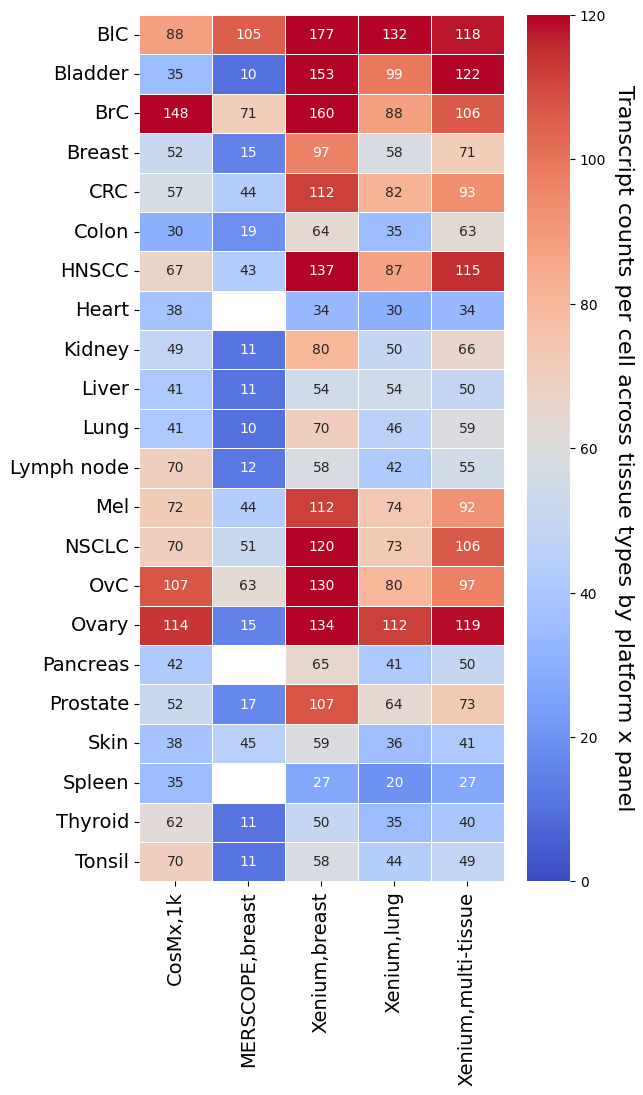

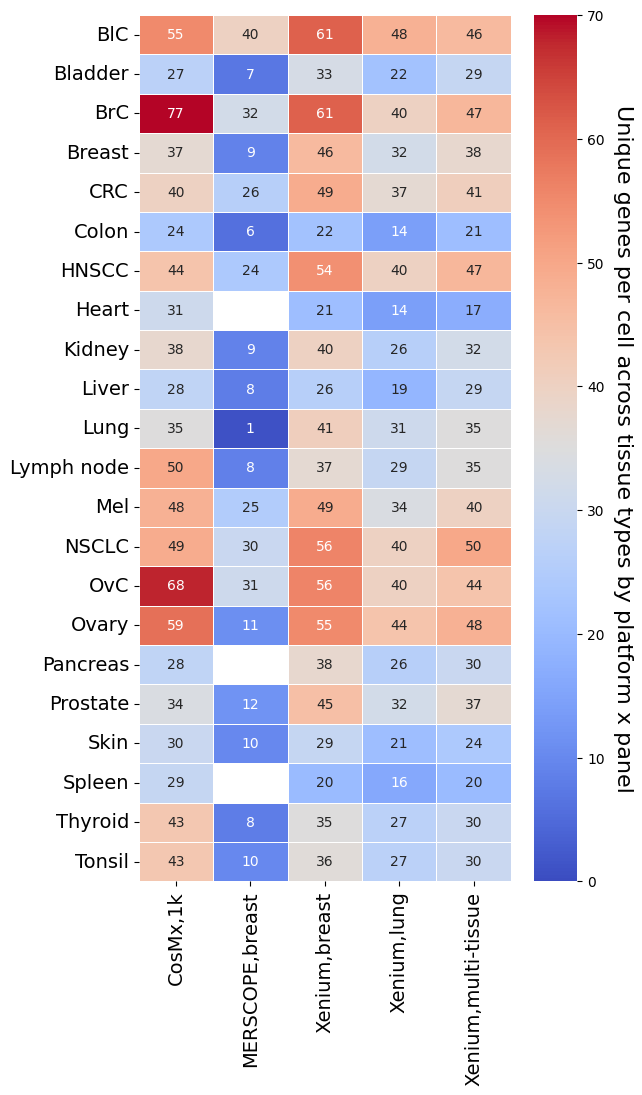

year 2023, share genes only True


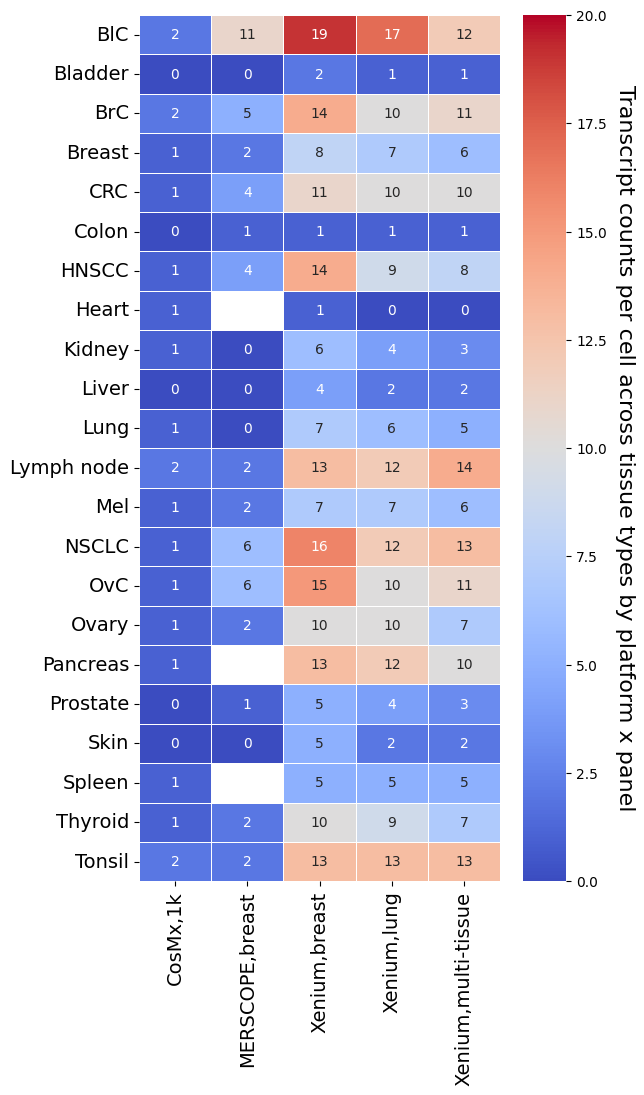

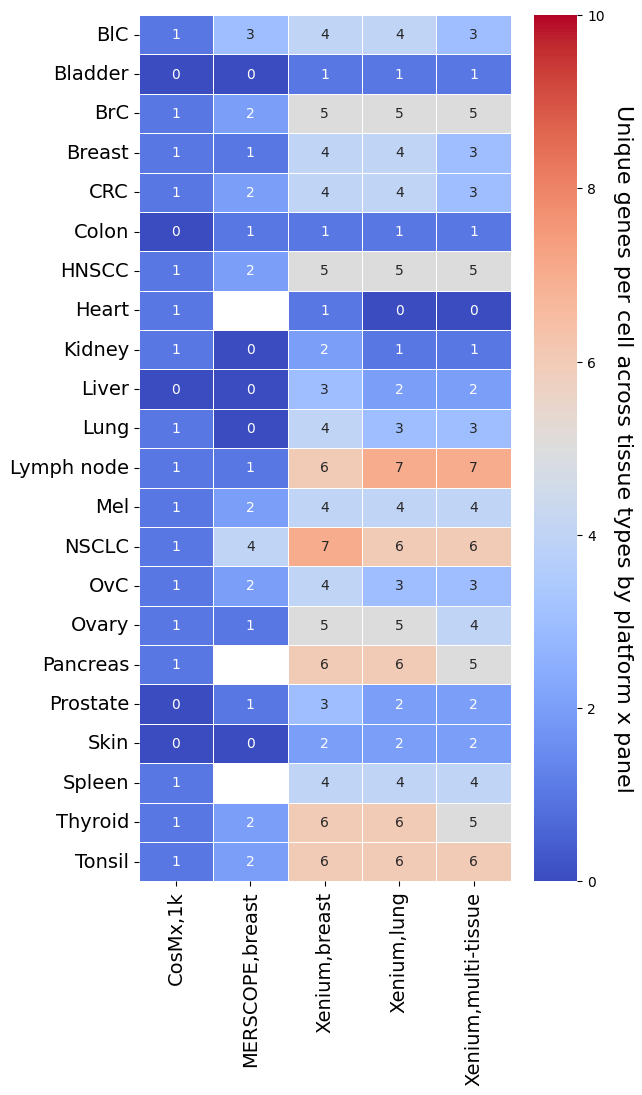

['2024_xenium_breast_htma', '2024_xenium_breast_tumor2', '2024_merscope_breast_htma', '2024_merscope_breast_tumor2', '2024_cosmx_multitissue_htma', '2024_cosmx_multitissue_tumor2']
year 2024, share genes only False

before QC: 1411952
after QC using transcript count per cell: 1153855
after QC using unique genes per cell: 1153855
Good quality cells: 81.7


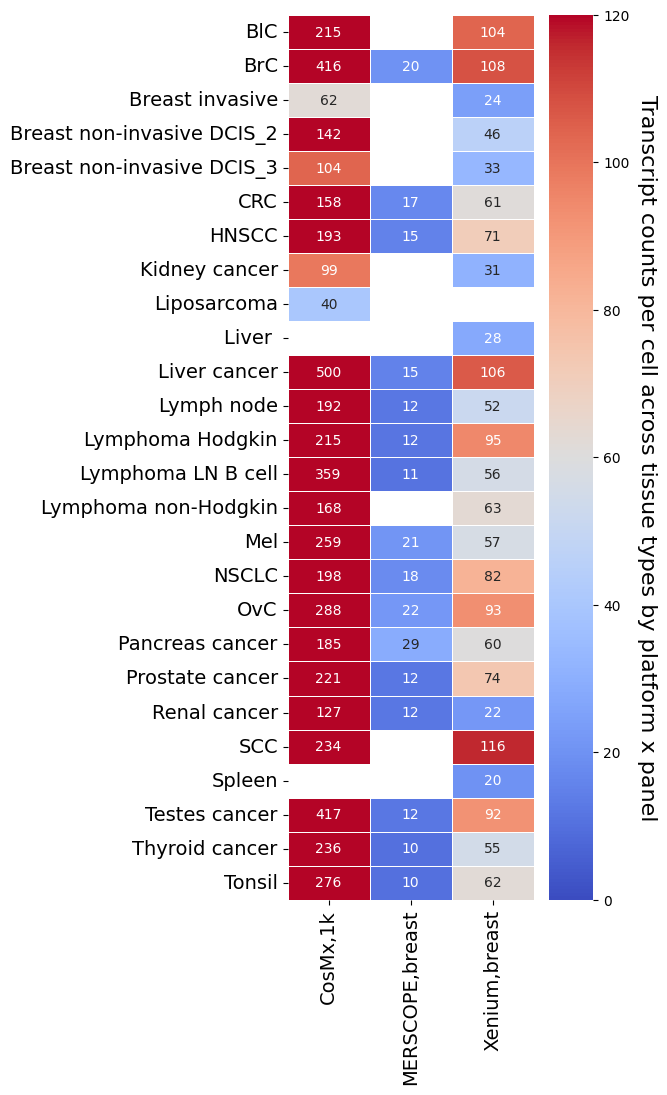

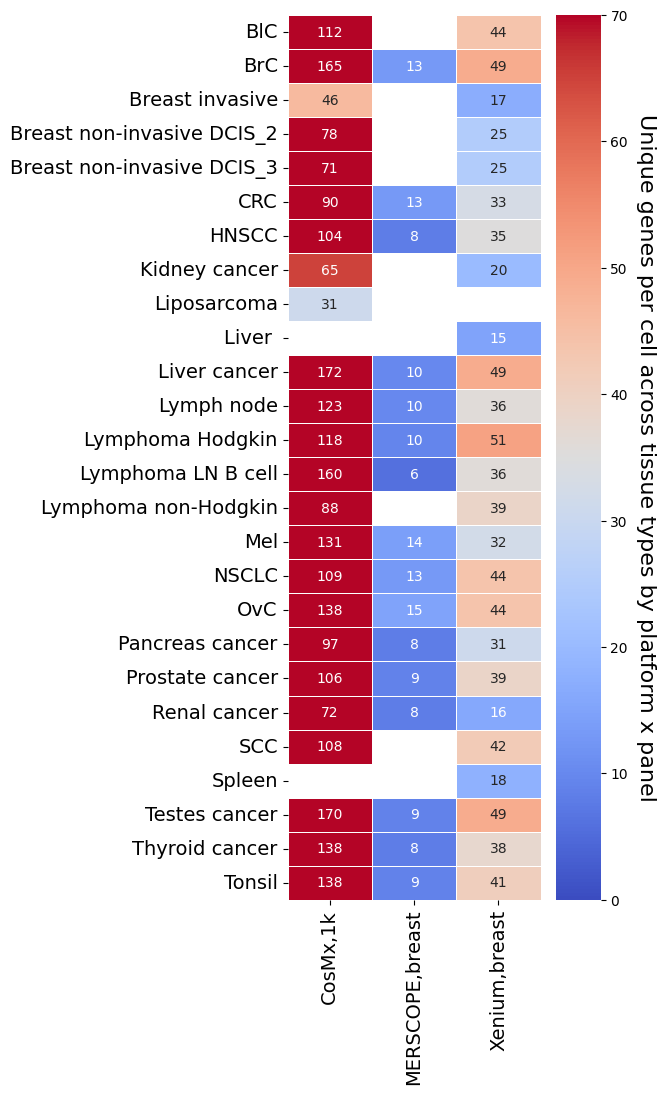

year 2024, share genes only True


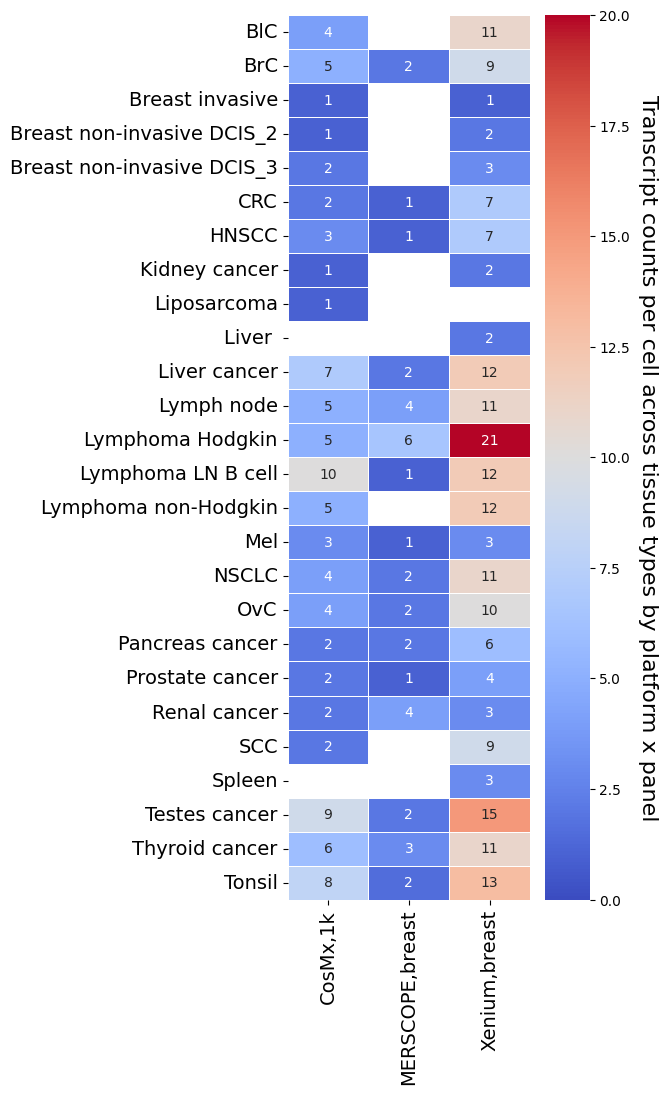

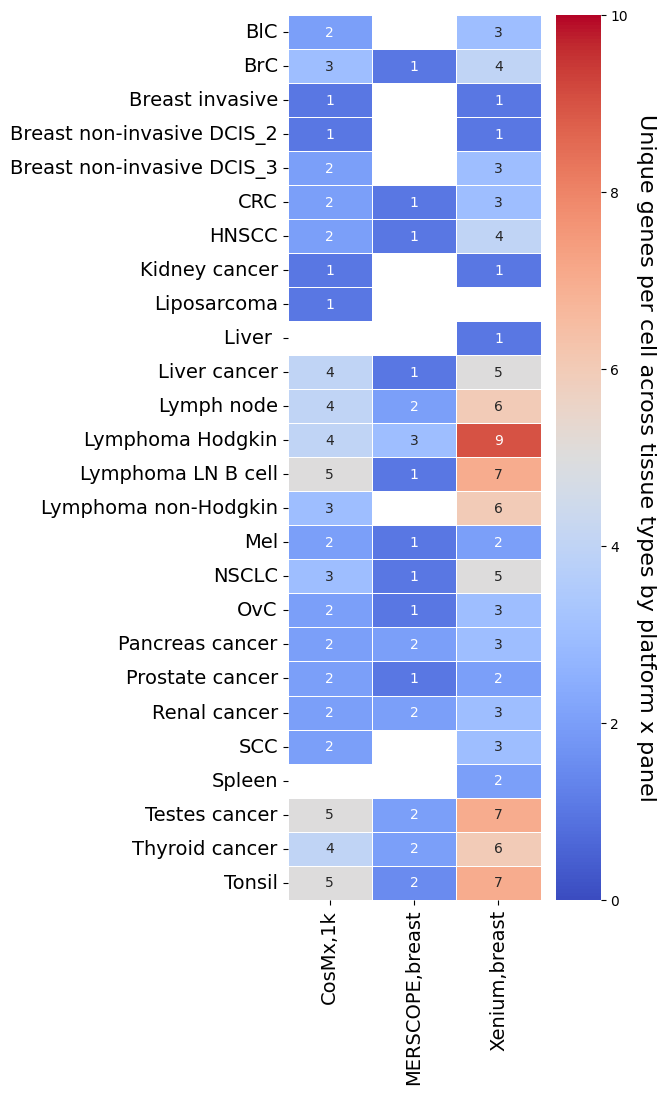

In [87]:
if not os.path.exists(f'{wd}/figures/Fig_4_Segmentation'):
    os.makedirs(f'{wd}/figures/Fig_4_Segmentation')


group_by = 'platform_panel' # platform_panel, sample

for year in ['2023', '2024']:

    if year == '2024':
        samples = [x for x in SAMPLES if '2024' in x]
    elif year == '2023':
        samples = [x for x in SAMPLES if '2024' not in x]
    else:
        samples = [x for x in SAMPLES]
    print (samples)

    for common in [False, True]:
        print (f"year {year}, share genes only {common}")
        if common:
            df_m = pd.read_parquet(f'{wd}/data/single_cell_metrics/all_cell_level_common_genes.parquet.gzip', engine='pyarrow')
            with open(f"{wd}/data/{year}_qced_cell_id", "rb") as fp:
                qced_cell_id = pickle.load(fp)
            df_mat = df_m.copy()
            df_mat['sample_cell_id'] = df_mat['sample'] + "_" + df_mat['cell_id']
            df_mat = df_mat.loc[df_mat['sample_cell_id'].isin(qced_cell_id)]
        else:
            df_m = pd.read_parquet(f'{wd}/data/single_cell_metrics/all_cell_level.parquet.gzip', engine='pyarrow')

            df_m = df_m.loc[~df_m['cell_id'].str.contains('-1_region') 
                            & ~df_m['tissue_type'].isin(['Renal pelvis'])]

            df_m = df_m.loc[df_m['sample'].isin(samples)]

            metric = 'transcript_counts'
            qc_count_threshold = 10
            qc_unique_gene_threshold = 0

            df_mat = df_m.copy()
            print (f'\nbefore QC: {len(df_mat)}')

            # Same threshold:10
            df_mat = df_mat.loc[df_mat['transcript_counts'] >= qc_count_threshold]

            # Different threshold: 10 for Xenium and MERSCOPE, 20 for CosMx
            df_mat = df_mat.loc[~((df_mat['platform'] == 'COSMX') & (df_mat['transcript_counts'] <= 20))]

            print (f'after QC using transcript count per cell: {len(df_mat)}')
            df_mat = df_mat.loc[df_mat['unique_genes'] >= qc_unique_gene_threshold]
            print (f'after QC using unique genes per cell: {len(df_mat)}')

            print (f'Good quality cells: {round(len(df_mat) * 100/len(df_m),1)}')
            df_mat['sample_cell_id'] = df_mat['sample'] + "_" + df_mat['cell_id']
            qced_cell_id = df_mat.sample_cell_id.to_list()
            with open(f"{wd}/data/{year}_qced_cell_id", "wb") as fp:
                pickle.dump(qced_cell_id, fp)

        for metric in ['transcript_counts', 'unique_genes']:
            df_plot = df_mat.groupby(by=[group_by, 'tissue_type'], as_index=False).agg({metric:'median'})
            df_plot = df_plot.pivot_table(index='tissue_type',columns=group_by,values=metric)
            # display(get_df_color(df_plot))

            vmax = 120
            if metric == 'unique_genes':
                vmax = 70

            if common:
                vmax = 20
                if metric == 'unique_genes':
                    vmax = 10

            # Create the heatmap with annotations
            plt.figure(figsize=(7, 11))  # Increase the figure width to accommodate the y-axis label

            df_plot_trim = df_plot
            if 'MERSCOPE,lung' in df_plot_trim.columns:
                df_plot_trim = df_plot.drop(columns=['MERSCOPE,lung'])
            df_plot_trim = round(df_plot_trim,2)
            g = sns.heatmap(df_plot_trim, annot=True, cmap='coolwarm', linewidths=0.5,
                            vmin=0, vmax=vmax, fmt=".0f")
            cbar = g.collections[0].colorbar

            # Adjust the position and size of the colorbar
            cbar.ax.set_position([0.91, 0.1, 0.02, 0.77])  # Adjust the first and third values
            cbar.ax.set_ylabel(f"{' '.join(metric.split('_')).capitalize()} per cell across tissue types by platform x panel", rotation=270, labelpad=20, fontsize=16)
            plt.xlabel('')
            plt.ylabel('')
            fontsize = 14
            xlabels = g.get_xticklabels()
            g.set_xticklabels(xlabels, fontsize=fontsize, rotation=90)
            ylabels = g.get_yticklabels()
            g.set_yticklabels(ylabels, fontsize=fontsize)

            plt.tight_layout()
   
            plt.savefig(f'{wd}/figures/Fig_4_Segmentation/Main_Fig_{metric}_{year}_{common}.png', dpi=250, transparent=True)
            # plt.savefig(f'{wd}/figures/Fig_4_Segmentation/Main_Fig_{metric}_{year}_{common}.eps', dpi=250, transparent=True)
            plt.show()


In [59]:
df_mat

,cell_id,tissue_type,core,transcript_counts_given,platform,panel,tma,platform_panel,sample,transcript_counts,unique_genes
2606935,aaacogpm-1,Lymph node,170,47.0,XENIUM,Breast,HTMA,"Xenium,breast",2024_xenium_breast_htma,13,7
2606936,aaacpfia-1,Lymph node,170,61.0,XENIUM,Breast,HTMA,"Xenium,breast",2024_xenium_breast_htma,21,12
2606937,aaadadeb-1,Lymph node,170,70.0,XENIUM,Breast,HTMA,"Xenium,breast",2024_xenium_breast_htma,16,5
2606938,aaaddaic-1,Lymph node,170,35.0,XENIUM,Breast,HTMA,"Xenium,breast",2024_xenium_breast_htma,20,11
2606939,aaadkjla-1,Lymph node,170,111.0,XENIUM,Breast,HTMA,"Xenium,breast",2024_xenium_breast_htma,29,7
...,...,...,...,...,...,...,...,...,...,...,...
4018115,c_2_9_291,BlC,304,816.0,COSMX,Multitissue,TUMOR2,"CosMx,1k",2024_cosmx_multitissue_tumor2,22,13
4018278,c_2_9_44,BlC,304,1175.0,COSMX,Multitissue,TUMOR2,"CosMx,1k",2024_cosmx_multitissue_tumor2,30,13
4018391,c_2_9_542,BlC,304,637.0,COSMX,Multitissue,TUMOR2,"CosMx,1k",2024_cosmx_multitissue_tumor2,21,5
4018628,c_2_9_76,BlC,304,1144.0,COSMX,Multitissue,TUMOR2,"CosMx,1k",2024_cosmx_multitissue_tumor2,27,11


In [57]:
df_mat[['platform_panel','tissue_type','transcript_counts','unique_genes']].groupby(['platform_panel','tissue_type']).mean()

transcript_counts  unique_genes
platform_panel  tissue_type                                                
CosMx,1k        BlC                                 30.916882      6.370370
                BrC                                 31.854865      9.351842
                Breast non-invasive DCIS_3          26.000000     11.000000
                CRC                                 27.547320      8.088940
                HNSCC                               25.770408     10.433673
                Kidney cancer                       24.187500      7.875000
                Liver cancer                        25.246269      8.220149
                Lymph node                          24.347594     12.422460
                Lymphoma Hodgkin                    26.212560      9.903382
                Lymphoma LN B cell                  26.523823      9.734046
                Lymphoma non-Hodgkin                25.086093      8.384106
                Mel                                 29.407895      8.532895
                NSCLC                               30.097579      9.537784
                OvC                                 30.500219      9.823168
                Pancreas cancer                     25.142857      8.452381
                Prostate cancer                     25.722222      7.462963
                Renal cancer                        29.354167      9.875000
                SCC                                 25.714286     10.857143
                Testes cancer                       29.152475      9.955776
                Thyroid cancer                      26.080893     11.361925
                Tonsil                              28.004007      9.127505
MERSCOPE,breast BrC                                 15.278438      4.353141
                CRC                                 11.000000      4.000000
                HNSCC                               16.000000      1.000000
                Liver cancer                        13.302326      4.162791
                Lymph node                          12.428571      5.285714
                Mel                                 13.608696      2.956522
                NSCLC                               14.182692      4.105769
                OvC                                 16.176860      3.688430
                Renal cancer                        15.000000      3.000000
                Testes cancer                       11.666667      5.000000
Xenium,breast   BlC                                 29.184724      4.359661
                BrC                                 31.341312      8.065897
                Breast invasive                     13.162162      5.108108
                Breast non-invasive DCIS_2          13.492754      5.550725
                Breast non-invasive DCIS_3          13.791667      5.979167
                CRC                                 22.886979      5.288550
                HNSCC                               28.639515      6.368680
                Kidney cancer                       15.268734      5.105943
                Liver                               15.283784      5.743243
                Liver cancer                        22.845095      7.045116
                Lymph node                          17.310451      7.945768
                Lymphoma Hodgkin                    26.845822      9.865908
                Lymphoma LN B cell                  17.556116      8.639763
                Lymphoma non-Hodgkin                17.976911      7.739520
                Mel                                 18.585510      6.880269
                NSCLC                               27.385379      8.224625
                OvC                                 25.962456      5.561291
                Pancreas cancer                     22.596069      5.234032
                Prostate cancer                     15.739629      4.317299
                Renal cancer                        15.381636      7.117647
                

In [58]:
df_m[['platform_panel','tissue_type','transcript_counts','unique_genes']].groupby(['platform_panel','tissue_type']).mean()

transcript_counts  unique_genes
platform_panel  tissue_type                                                
CosMx,1k        BlC                                  7.166242      2.756579
                BrC                                  8.115021      3.774088
                Breast invasive                      1.230038      1.016974
                Breast non-invasive DCIS_2           1.798761      1.337876
                Breast non-invasive DCIS_3           2.553230      1.787534
                CRC                                  3.858700      2.066892
                HNSCC                                3.638209      2.528572
                Kidney cancer                        1.992183      1.448241
                Liposarcoma                          0.572508      0.453676
                Liver cancer                         8.152964      4.025867
                Lymph node                           6.099797      4.267412
                Lymphoma Hodgkin                     5.780916      3.751187
                Lymphoma LN B cell                  11.415037      5.644445
                Lymphoma non-Hodgkin                 5.864504      3.212707
                Mel                                  3.194812      2.260692
                NSCLC                                5.321608      3.108422
                OvC                                  6.049569      2.941938
                Pancreas cancer                      3.326630      2.042891
                Prostate cancer                      3.067147      1.847102
                Renal cancer                         2.768003      1.944349
                SCC                                  3.027314      2.243080
                Testes cancer                       10.932381      5.277940
                Thyroid cancer                       7.551598      4.638768
                Tonsil                               9.446772      4.930211
MERSCOPE,breast BlC                                  0.190361      0.181325
                BrC                                  2.025696      1.075196
                Breast invasive                      0.137255      0.124183
                Breast non-invasive DCIS_2           0.132812      0.113281
                Breast non-invasive DCIS_3           0.105263      0.105263
                CRC                                  0.519506      0.349884
                HNSCC                                0.359157      0.306253
                Kidney cancer                        0.112717      0.108382
                Liver                                0.144814      0.138291
                Liver cancer                         1.138255      0.838614
                Lymph node                           1.437424      0.997177
                Lymphoma Hodgkin                     0.444136      0.345294
                Lymphoma LN B cell                   0.567071      0.485579
                Lymphoma non-Hodgkin                 0.337725      0.320359
                Mel                                  0.485379      0.391818
                NSCLC                                1.091062      0.767801
                OvC                                  1.793154      0.871448
                Pancreas cancer                      0.122428      0.096839
                Prostate cancer                      0.286330      0.230082
                Renal cancer                         0.430331      0.352585
                SCC                                  0.062696      0.062069
                Spleen                               0.090909      0.090909
                Testes cancer                        0.745445      0.621431
                Thyroid cancer                       0.373700      0.356230
                Tonsil                               0.482559      0.430375
Xenium,breast   BlC                                 16.436892      3.261313
                BrC                                 16.270561      4.943598
                

In [24]:
df_all = pd.DataFrame()

for sample in SAMPLES:
    df_c = pd.read_parquet(
        f'{wd}/data/cell_level_csv/{sample}_cell_level.parquet.gzip'
        )
    
    df_c = df_c.loc[~df_c['cell_id'].str.contains('-1_region')]
    pas = []
    transcript_thresholds = []
    for i in range(0,21,1):
        transcript_thresholds.append(i)
        pa = round(len(df_c.loc[df_c['transcript_counts'] >= i]) * 100 /len(df_c),2)
        pas.append(pa)

    df = pd.DataFrame({'transcript_threshold':transcript_thresholds, 'percentage':pas})
    df['Sample'] = sample
    df_all = pd.concat([df_all, df])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


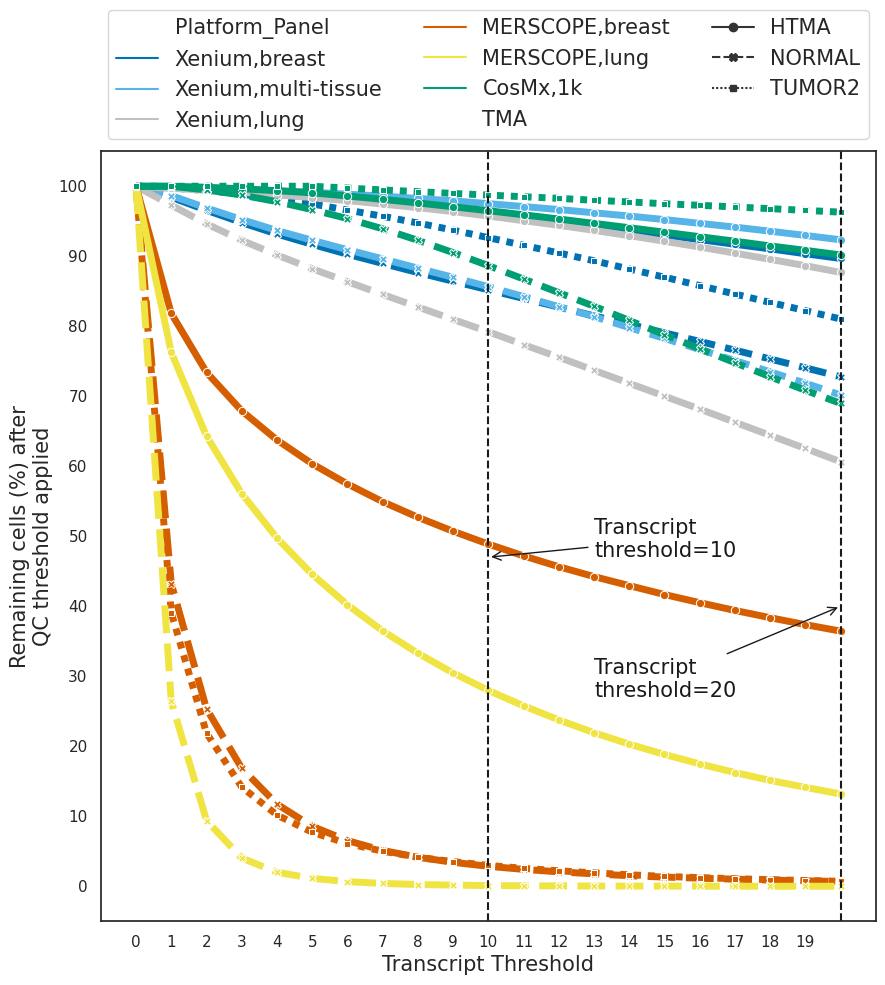

In [50]:
df_plot= df_all.copy()

df_plot['TMA'] = df_plot['Sample'].apply(lambda x: f"{x.split('_')[-1].upper()}")
df_plot['Platform_Panel'] = df_plot['Sample'].apply(lambda x: f"{x.split('_')[-3].upper()}_{x.split('_')[-2].capitalize()}")
df_plot = correct_platform_panel(df_plot, 'Platform_Panel')


custom_color_dict = {}
for platform_panel in df_plot['Platform_Panel'].unique():
    custom_color_dict[platform_panel] = sample_color[platform_panel]

fontsize = 15
plt.figure(figsize=(10, 10))
sns.set_theme(style="white")
ax = sns.lineplot(data=df_plot, 
             x='transcript_threshold', 
             y='percentage', 
             hue='Platform_Panel',
            #  drawstyle='steps-post', 
             palette = custom_color_dict,
             style='TMA',
             markers=True,
             linewidth = 5,
             ci=None)
threshold = 10
ax.axvline(x=threshold, color='k', linestyle='--')
ax.axvline(x=20, color='k', linestyle='--')
plt.annotate(f'Transcript\nthreshold={threshold}', xy=(10, 47), xytext=(13, 47),
             arrowprops=dict(arrowstyle='->', color='k'),
             fontsize=fontsize, color='k')

plt.annotate(f'Transcript\nthreshold=20', xy=(20, 40), xytext=(13, 27),
             arrowprops=dict(arrowstyle='->', color='k'),
             fontsize=fontsize, color='k')

x_ticks = np.arange(df_all['transcript_threshold'].min(), df_all['transcript_threshold'].max(), 1)
y_ticks = np.arange(0, 110, 10)
plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.xlabel('Transcript Threshold', fontsize=fontsize)
plt.ylabel('Remaining cells (%) after\nQC threshold applied', fontsize=fontsize)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center',ncol=3,borderaxespad=0., fontsize=fontsize)
plt.savefig(f'{wd}/figures/Fig_4_Segmentation/Main_Fig_4D_filtration.png', bbox_inches='tight', dpi=250, transparent=True)
plt.savefig(f'{wd}/figures/Fig_4_Segmentation/Main_Fig_4D_filtration.eps', bbox_inches='tight', dpi=250, transparent=True)
plt.show()

In [13]:


for i in [10,20]:
    df_plot_selected = df_plot.loc[df_plot['transcript_threshold'].isin([i])]
    df_plot_selected = df_plot_selected.rename(columns={'transcript_threshold':'Transcript Threshold','percentage':'Good Cells (%)'})
    df_plot_selected['TMA'] = df_plot_selected['Sample'].apply(lambda x: x.split('_')[-1].upper())
    df_plot_selected = df_plot_selected.sort_values(by=['Transcript Threshold', 'TMA','Good Cells (%)'], ascending=True)
    df_plot_selected = df_plot_selected[['TMA','Sample','Platform_Panel','Transcript Threshold', 'Good Cells (%)']]
    df_plot_selected.to_csv(f'{wd}/tables/qc{i}.csv', index=False)
    display(df_plot_selected)

,TMA,Sample,Platform_Panel,Transcript Threshold,Good Cells (%)
10,HTMA,2024_merscope_breast_htma,"MERSCOPE,breast",10,27.97
10,HTMA,merscope_lung_htma,"MERSCOPE,lung",10,27.98
10,HTMA,merscope_breast_htma,"MERSCOPE,breast",10,69.79
10,HTMA,cosmx_multitissue_htma,"CosMx,1k",10,94.13
10,HTMA,2024_xenium_breast_htma,"Xenium,breast",10,94.28
10,HTMA,xenium_lung_htma,"Xenium,lung",10,95.75
10,HTMA,xenium_panhuman_htma,"Xenium,multi-tissue",10,97.52
10,HTMA,xenium_breast_htma,"Xenium,breast",10,97.79
10,NORMAL,merscope_lung_normal,"MERSCOPE,lung",10,0.10
10,NORMAL,merscope_breast_normal,"MERSCOPE,breast",10,2.85


,TMA,Sample,Platform_Panel,Transcript Threshold,Good Cells (%)
20,HTMA,merscope_lung_htma,"MERSCOPE,lung",20,13.18
20,HTMA,2024_merscope_breast_htma,"MERSCOPE,breast",20,14.12
20,HTMA,merscope_breast_htma,"MERSCOPE,breast",20,58.78
20,HTMA,cosmx_multitissue_htma,"CosMx,1k",20,84.40
20,HTMA,2024_xenium_breast_htma,"Xenium,breast",20,86.04
20,HTMA,xenium_lung_htma,"Xenium,lung",20,87.69
20,HTMA,xenium_panhuman_htma,"Xenium,multi-tissue",20,92.35
20,HTMA,xenium_breast_htma,"Xenium,breast",20,93.32
20,NORMAL,merscope_lung_normal,"MERSCOPE,lung",20,0.00
20,NORMAL,merscope_breast_normal,"MERSCOPE,breast",20,0.67


In [19]:
df_plot_selected = df_plot.loc[df_plot['transcript_threshold']==20]
df_plot_selected = df_plot_selected.rename(columns={'transcript_threshold':'Transcript Threshold','percentage':'Good Cells (%)'})
df_plot_selected['TMA'] = df_plot_selected['Sample'].apply(lambda x: x.split('_')[-1].upper())
df_plot_selected = df_plot_selected.sort_values(by=['TMA','Transcript Threshold', 'Good Cells (%)'], ascending=False)
df_plot_selected = df_plot_selected[['TMA','Sample','Platform_Panel','Transcript Threshold', 'Good Cells (%)']]
df_plot_selected.to_csv(f'{wd}/tables/qc_20.csv', index=False)
df_plot_selected

,TMA,Sample,Platform_Panel,Transcript Threshold,Good Cells (%)
20,TUMOR2,2024_xenium_breast_tumor2,"Xenium,breast",20,81.04
20,TUMOR2,2024_merscope_breast_tumor2,"MERSCOPE,breast",20,0.71
20,NORMAL,xenium_breast_normal,"Xenium,breast",20,72.78
20,NORMAL,xenium_panhuman_normal,"Xenium,multi-tissue",20,70.17
20,NORMAL,cosmx_multitissue_normal,"CosMx,1k",20,68.98
20,NORMAL,xenium_lung_normal,"Xenium,lung",20,60.65
20,NORMAL,merscope_breast_normal,"MERSCOPE,breast",20,0.67
20,NORMAL,merscope_lung_normal,"MERSCOPE,lung",20,0.00
20,HTMA,xenium_breast_htma,"Xenium,breast",20,93.32
20,HTMA,xenium_panhuman_htma,"Xenium,multi-tissue",20,92.35


In [15]:

groupby='Platform_Panel'

df_metric = df_plot_selected.copy()
df_metric = df_metric.groupby(by = [groupby]).agg({'Good Cells (%)':'median'})
df_metric = df_metric.sort_values(by=['Good Cells (%)'], ascending=False)
df_metric = df_metric.round(1)
# df_metric.to_csv(f'{wd}/tables/cell_per_area_by_platform.csv', index=True)
df_metric

,Good Cells (%)
Platform_Panel,
"Xenium,breast",83.5
"Xenium,multi-tissue",81.3
"CosMx,1k",76.7
"Xenium,lung",74.2
"MERSCOPE,breast",7.4
"MERSCOPE,lung",6.6
